In [59]:
#Encerrar a conexão com os dispositivos
DAC.close()
scope.close()
rm.close()


In [1]:
import pyvisa as pv
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio   
import pickle
import scipy.signal
from tqdm.notebook import tqdm, trange
from scipy.special import erfc
import scipy as sp
from optic.comm.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample, decimate,clockSamplingInterp
from optic.comm.metrics import signal_power,fastBERcalc
from optic.dsp.equalization import *
from optic.plot import eyediagram
plt.rcParams["figure.figsize"] = (12,6)

from funcoesLab import *

c:\Users\lucas\anaconda3\envs\Opticompy\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# #Conectar dispositivos

rm = pv.ResourceManager()
print(rm.list_resources())

DAC = rm.open_resource('USB0::0x0957::0x5707::MY53802202::0::INSTR')

print('info DAC:', DAC.query('*IDN?'))

DAC.write('*rst')
DAC.write('*opc?') 

scope = rm.open_resource('USB0::0x2A8D::0x1768::MY55440748::0::INSTR')
print('Info Osciloscopio:', scope.query('*IDN?'))
scope.write('*rst')
scope.write('*opc?') 

np.set_printoptions(threshold=np.inf)
del DAC.timeout
print('')

('USB0::0x0957::0x5707::MY53802202::0::INSTR', 'USB0::0x2A8D::0x1768::MY55440748::0::INSTR')
info DAC: Agilent Technologies,33622A,MY53802202,A.01.11-2.25-03-64-02

Info Osciloscopio: KEYSIGHT TECHNOLOGIES,DSO-X 3014T,MY55440748,04.06.2015051201




In [4]:
Modulador = {
    'M': 4,
    'nsimbolos': 8e5,
    'SPS': 3,
    'formatoPulso': 'rrc', #'rect','nrz','rrc'
    'nTaps': 1024,
    'alpha': 0.01,
    'W': np.array([])
}

Dac = {
    'dispositivo': DAC,
    'Porta': 2,
    'fs': 600e6,
    'V_High': 4,
    'V_Low': 0,
    'filtro': 'NORMal'
}

Osciloscopio = {
    'dispositivo': scope,
    'canais': np.array([3]),
    'tempo': Modulador['nsimbolos']/(Dac['fs']),
    'vDivisao': np.array([0.4]),
    'impedancia': np.array(['FIFTy']),
    'triggerChannel': np.array([0]),
    'triggerAmp': np.array([0]),
    'offset': np.array([2]),
}
#Gerando os sinais transmitidos
bits,pulso, transmitido, transmitidoequalizados = Gerar_Simbolos(Modulador)
transmitido = clockSamplingInterp(transmitido.reshape(-1,1),Fs_in=Dac['fs']*Modulador['SPS'],Fs_out=Dac['fs']*1.5,jitter_rms=0)[:,0]
transmitido = transmitido.real
transmitido = transmitido - np.min(transmitido)
transmitido = transmitido/np.max(transmitido)*65534
transmitido = transmitido - 32767
transmitido = (np.rint(transmitido)).astype(int)

#Gerando uma onda arbitraria no DAC
Modulador['SPS'] = 1.5
Onda_Dac_Keysight(Dac,Modulador,transmitido,'teste')
DAC.query('*OPC?')   
#Configurando o osciloscopio
ConfigurarScope(Osciloscopio)
# Fixar o sinal no osciloscopio
Osciloscopio['dispositivo'].write('digitize')
Osciloscopio['dispositivo'].query('*OPC?')   

t,recebido = AdquirirOnda(Osciloscopio['dispositivo'],3)
fsScope = float(Osciloscopio['dispositivo'].query(':ACQuire:SRATe?'))

print(f'Numero de pontos do osciloscopio: {len(recebido)}')
print(f'Frequencia de amostragem do osciloscopio: {round(fsScope*1e-6,3)} MHz')



-410,"Query INTERRUPTED"

Numero de pontos do osciloscopio: 1333000
Frequencia de amostragem do osciloscopio: 1000.0 MHz


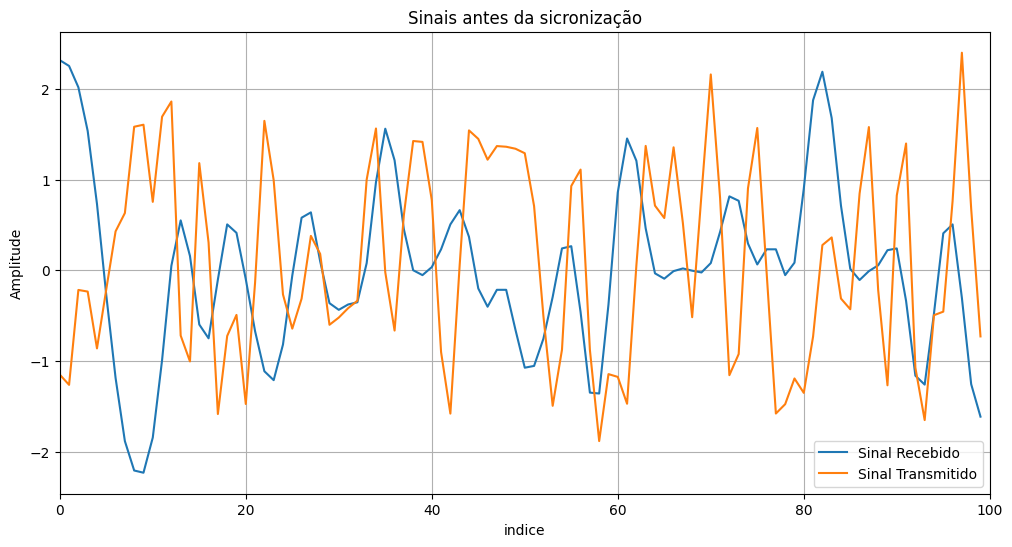

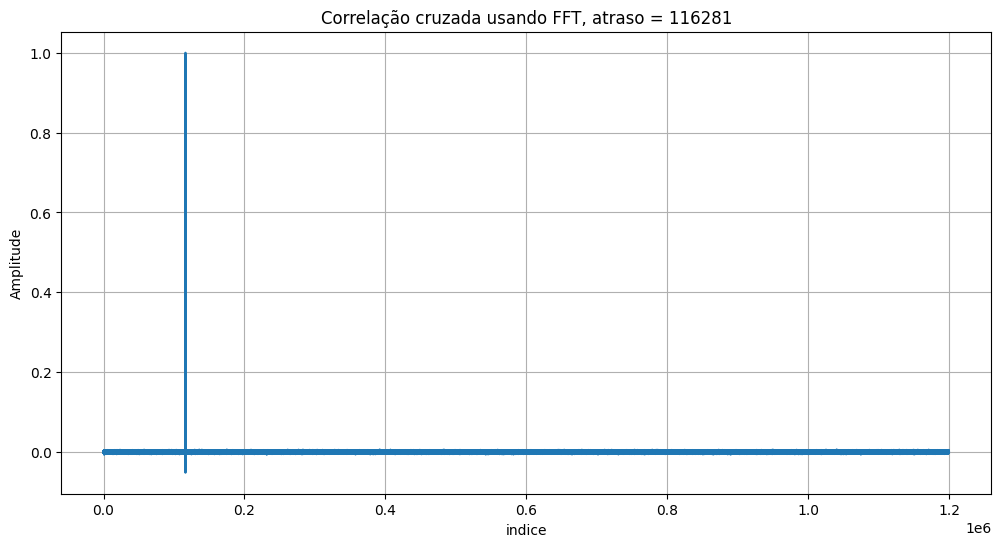

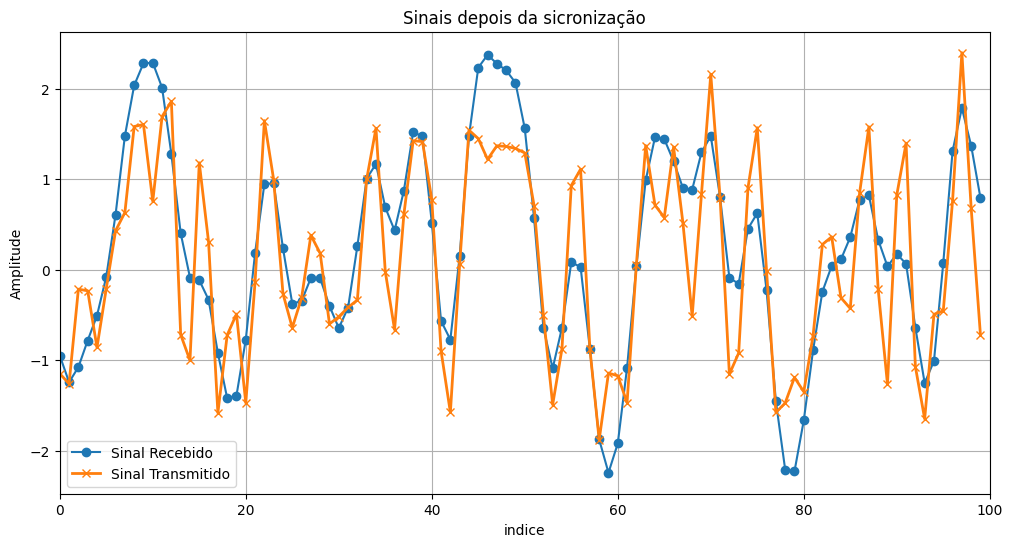

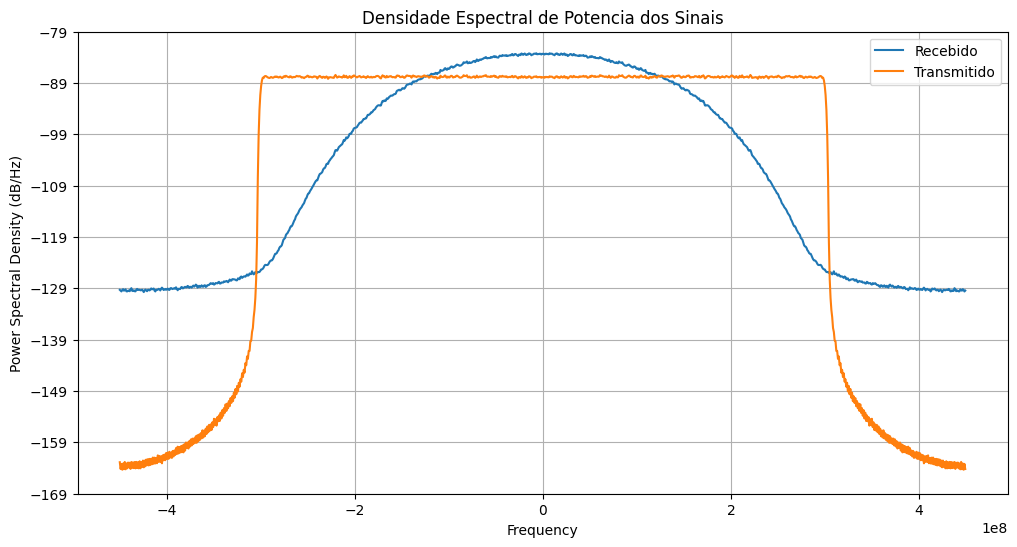

In [5]:
transmitido = pnorm(transmitido-np.mean(transmitido))

recebidodecimado = clockSamplingInterp(recebido.reshape(-1,1),Fs_in=fsScope,Fs_out=Dac['fs']*1.5,jitter_rms=0)[:,0]
recebidodecimado = pnorm(recebidodecimado-np.mean(recebidodecimado))

plt.figure()
plt.plot(recebidodecimado[0:100],label='Sinal Recebido')
plt.plot(transmitido[0:100],label='Sinal Transmitido')
plt.xlim(0,100)
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.title('Sinais antes da sicronização')


recebidosicronizado = sicronizarSinais(recebidodecimado,(transmitido),plot=True)
recebidosicronizado = pnorm(recebidosicronizado-np.mean(recebidosicronizado))

plt.figure()
plt.plot(recebidosicronizado[0:100],'-o',label='Sinal Recebido')
plt.plot(transmitido[0:100],'-x',linewidth='2',label='Sinal Transmitido')
plt.xlim(0,100)
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.title('Sinais depois da sicronização')

plt.figure()
plt.title('Densidade Espectral de Potencia dos Sinais')
plt.psd(recebidosicronizado,Fs=Dac['fs']*Modulador['SPS'], NFFT = 1024, sides='twosided', label = 'Recebido')
plt.psd(transmitido,Fs=Dac['fs']*Modulador['SPS'], NFFT = 1024, sides='twosided', label = 'Transmitido')
plt.legend()


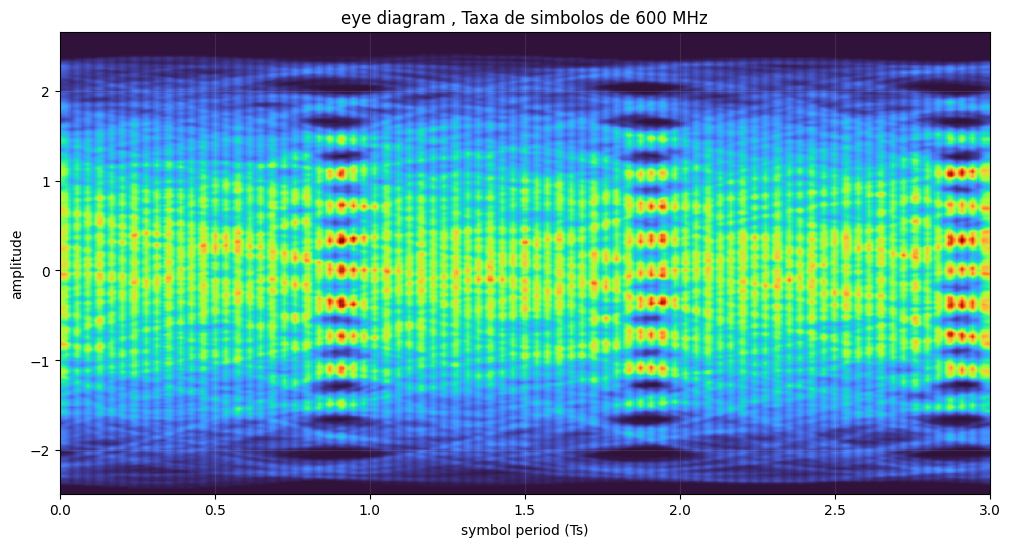

In [212]:
from optic.plot import eyediagram
eyediagram(recebidosicronizado, len(recebidosicronizado), 1.5,plotlabel=', Taxa de simbolos de 600 MHz', ptype='fancy')

In [210]:
BER, SER, SNR = fastBERcalc(pnorm(recebidosicronizado), pnorm(transmitido), 4, 'pam')
print(BER)
print(SER)
print(SNR)

[0.26674375]
[0.49186667]
[3.39612627]


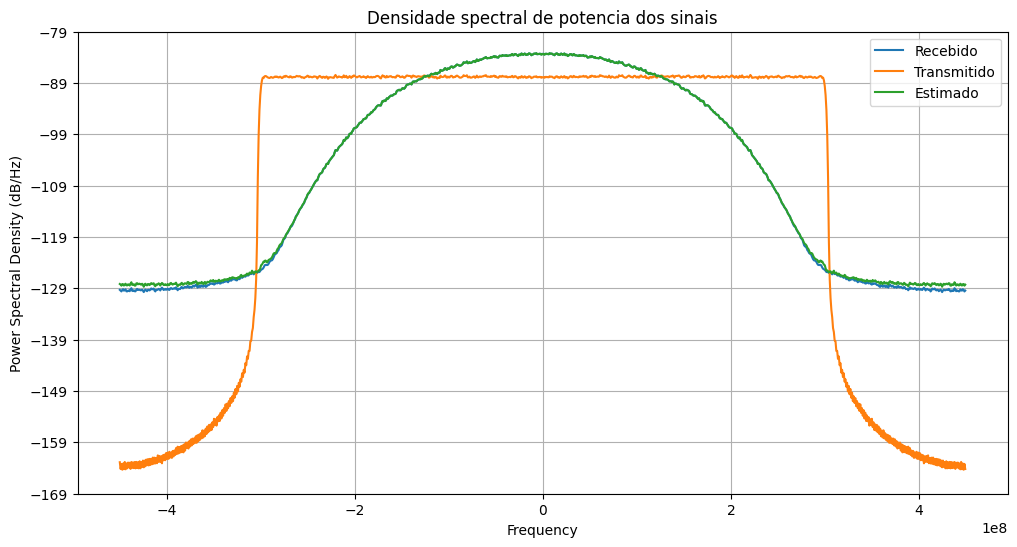

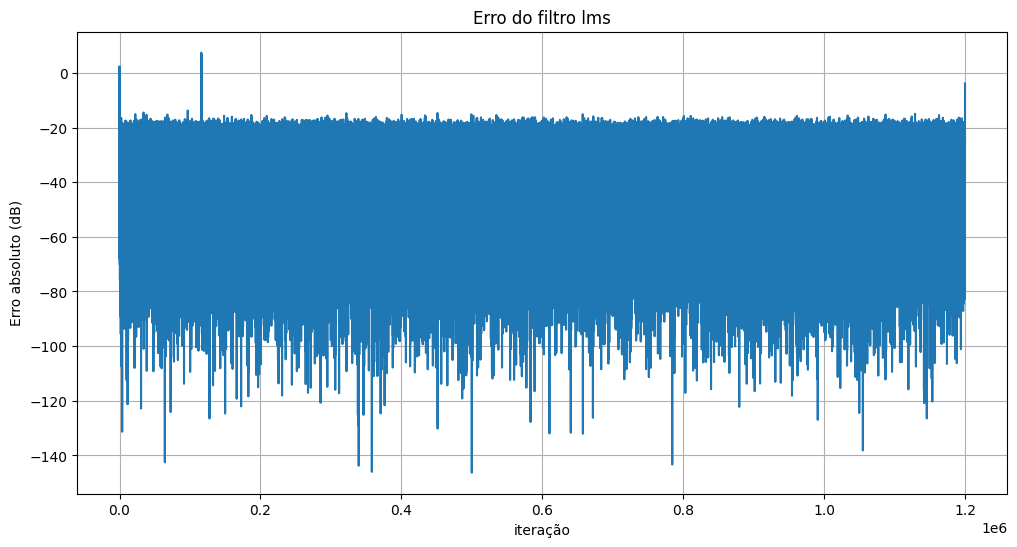

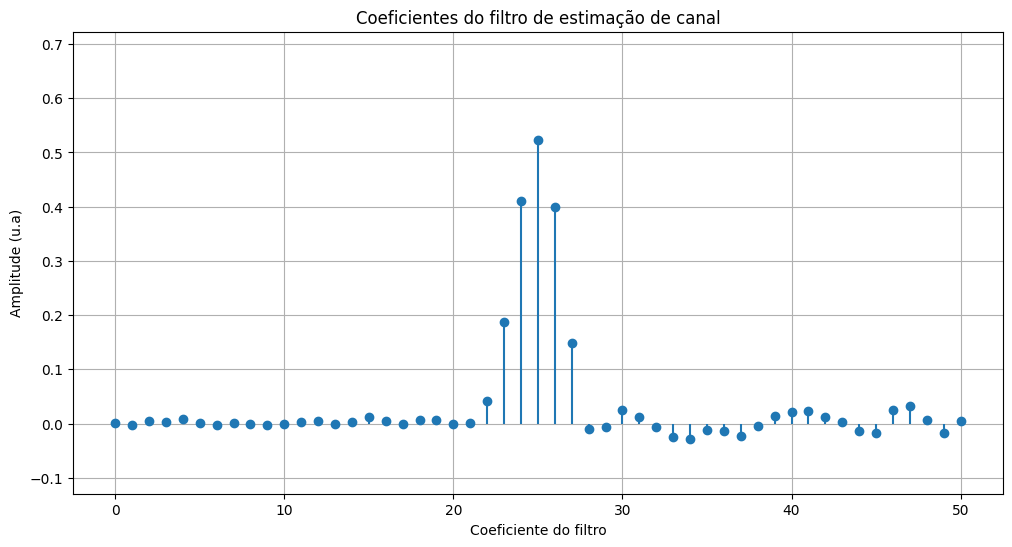

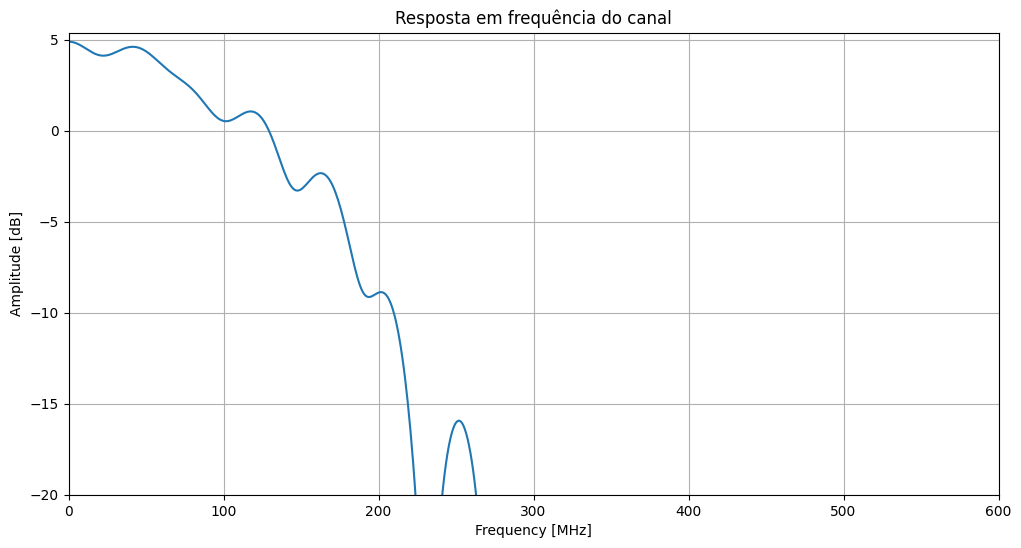

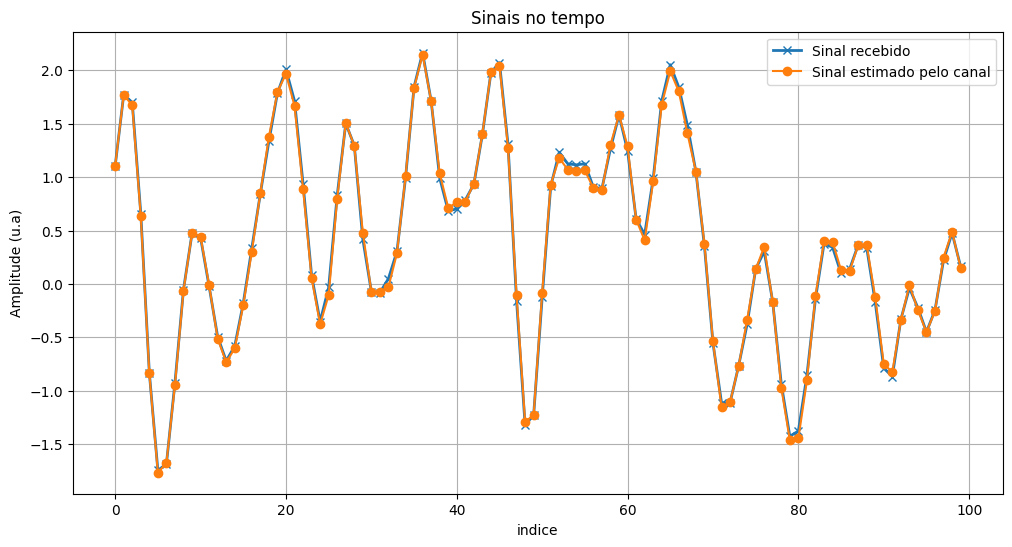

In [6]:
#Estimação do canal

#filtro lms
L = 51
μ = 0.02
out, h ,erro = lms(transmitido, recebidosicronizado, L,μ)
out = pnorm(out-np.mean(out))

plt.figure()
plt.psd(recebidosicronizado,Fs=Dac['fs']*Modulador['SPS'],NFFT = 1024, sides='twosided', label = 'Recebido')
plt.psd(transmitido,Fs=Dac['fs']*Modulador['SPS'],NFFT = 1024, sides='twosided', label = 'Transmitido')
plt.psd(out, sides='twosided',Fs=Dac['fs']*Modulador['SPS'],NFFT = 1024, label = 'Estimado')
plt.legend()
plt.title('Densidade spectral de potencia dos sinais')

plt.figure()
plt.plot(10*np.log10(erro))
plt.xlabel('iteração')
plt.ylabel('Erro absoluto (dB)')
plt.title('Erro do filtro lms')
plt.grid()

plt.figure()
plt.stem(np.arange(len(h)), h, basefmt=" ")
plt.grid()
plt.ylim(min(h)-0.1,max(h)+0.2)
plt.xlabel('Coeficiente do filtro')
plt.ylabel('Amplitude (u.a)')
plt.title('Coeficientes do filtro de estimação de canal')

plt.figure()
fs = Dac['fs']*Modulador['SPS']
ω, h = sp.signal.freqz(b=h, a=1)
x = ω * fs * 1.0 / (2 * np.pi)
y = 20*np.log10(np.abs(h))

plt.plot(x/1e6, y)
plt.title('Resposta em frequência do canal')
plt.grid()
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [MHz]')
plt.xlim(0,1*Dac['fs']/1e6)
plt.ylim(-20,1.1*np.max(y))

plt.figure()
plt.plot(recebidosicronizado[500:600],'-x',linewidth='2',label='Sinal recebido')
plt.plot(out[500:600],'-o',label='Sinal estimado pelo canal')
plt.xlabel('indice')
plt.ylabel('Amplitude (u.a)')
plt.title('Sinais no tempo')
plt.grid()
plt.legend()

In [7]:
print(len(recebidosicronizado))
len(transmitido)

1200000


1200000

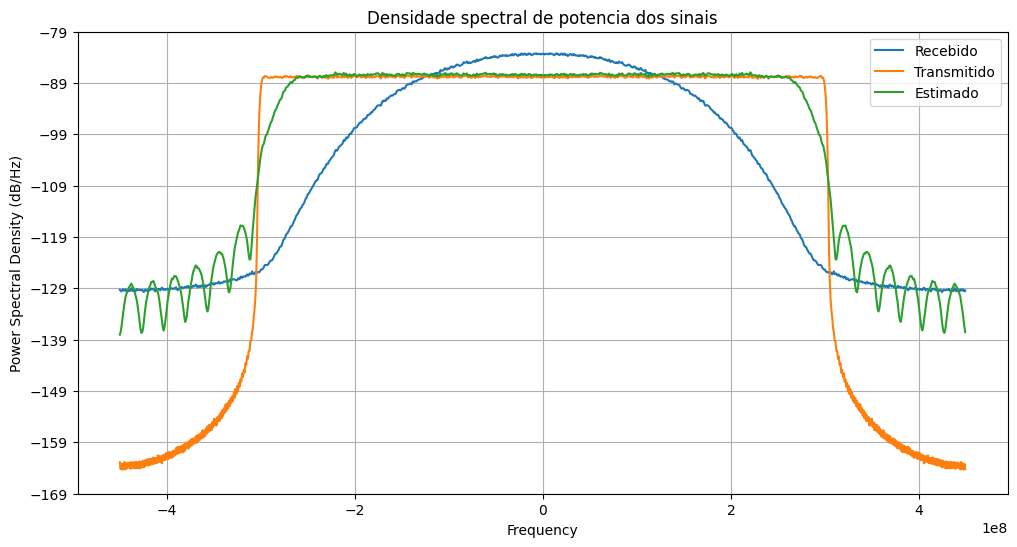

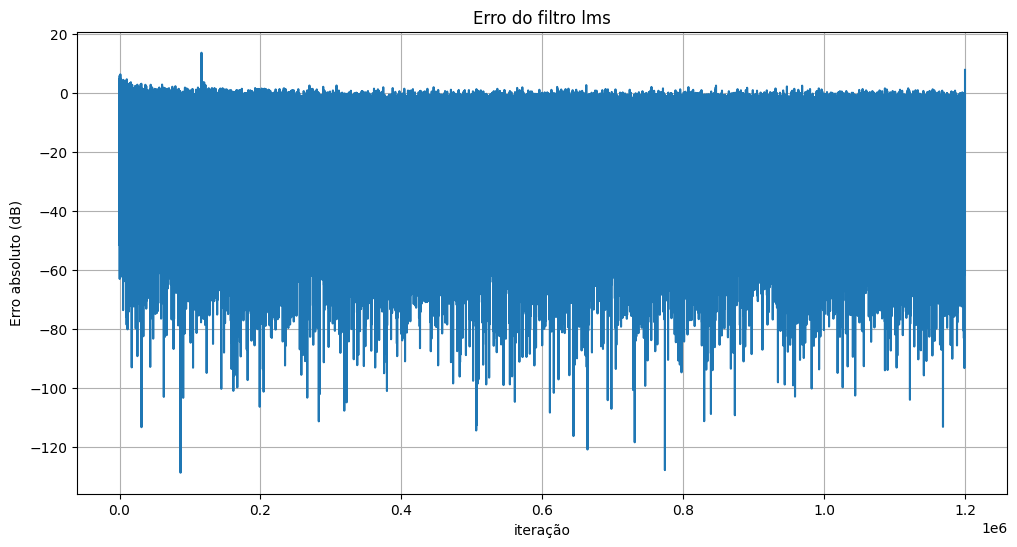

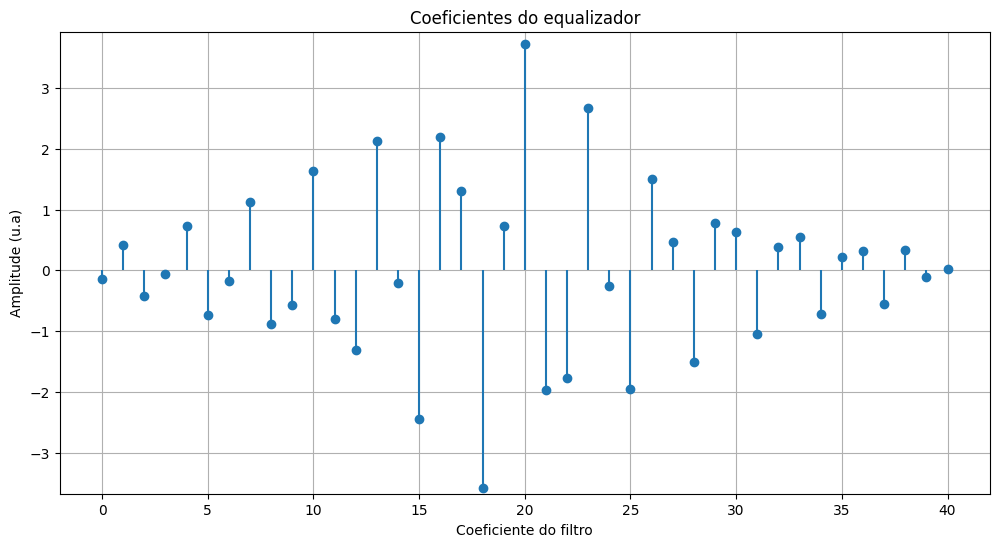

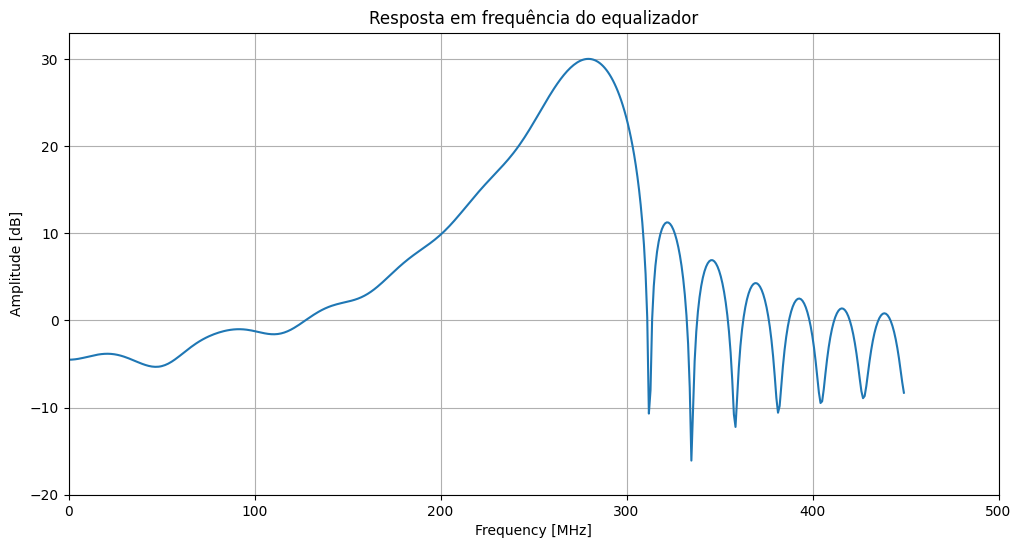

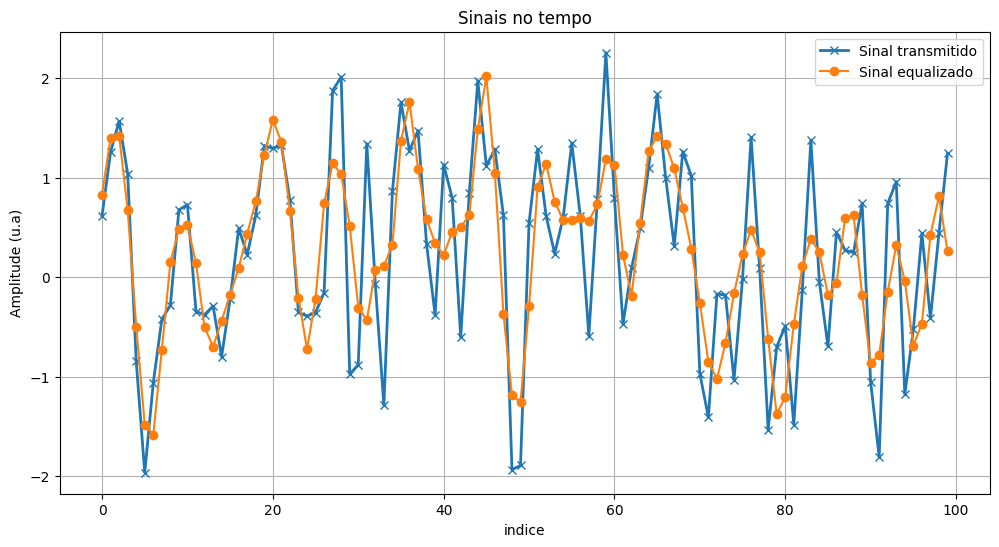

In [10]:
#Estimação do equalizador

#filtro lms
L = 41
μ = 0.005
out, heq ,erro = lms(recebidosicronizado[0:len(transmitido)], transmitido, L,μ)
out = pnorm(out-np.mean(out))



plt.figure()
plt.psd(recebidosicronizado,Fs=Dac['fs']*Modulador['SPS'],NFFT = 1024, sides='twosided', label = 'Recebido')
plt.psd(transmitido,Fs=Dac['fs']*Modulador['SPS'],NFFT = 1024, sides='twosided', label = 'Transmitido')
plt.psd(out, sides='twosided',Fs=Dac['fs']*Modulador['SPS'],NFFT = 1024, label = 'Estimado')
plt.legend()
plt.title('Densidade spectral de potencia dos sinais')

plt.figure()
plt.plot(10*np.log10(erro))
plt.xlabel('iteração')
plt.ylabel('Erro absoluto (dB)')
plt.title('Erro do filtro lms')
plt.grid()

plt.figure()
plt.stem(np.arange(len(heq)), heq, basefmt=" ")
plt.grid()
plt.ylim(min(heq)-0.1,max(heq)+0.2)
plt.xlabel('Coeficiente do filtro')
plt.ylabel('Amplitude (u.a)')
plt.title('Coeficientes do equalizador')

plt.figure()
fs = Dac['fs']*Modulador['SPS']
ω, h = sp.signal.freqz(b=heq, a=1)
x = ω * fs * 1.0 / (2 * np.pi)
y = 20*np.log10(np.abs(h))

plt.plot(x/1e6, y)
plt.title('Resposta em frequência do equalizador')
plt.grid()
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [MHz]')
plt.xlim(0,500)
plt.ylim(-20,1.1*np.max(y))

plt.figure()
plt.plot(transmitido[500:600],'-x',linewidth='2',label='Sinal transmitido')
plt.plot(out[500:600],'-o',label='Sinal equalizado')
plt.xlabel('indice')
plt.ylabel('Amplitude (u.a)')
plt.title('Sinais no tempo')
plt.grid()
plt.legend()



# Realizando a pre-equalização

In [46]:
def AdquirirOnda(scope,canal):
    ##############################################################
    # Função para retornar a forma de onda de um canal 

    # Parametros:
    # scope (Objeto do pyvisa relacionado ao osciloscopio)
    # canal (int ou string: FFT): Canal para obter a forma de onda

    # Outputs:
    # t (array numpy): array representando o tempo dos pontos do sinal ou frequencia caso escolha FFT
    # y (array numpy): array representando a amplitude dos pontos do sinal
    ##############################################################

    if canal == 'FFT':
        scope.write(':WAVeform:SOURce FFT')
    else:
        scope.write(f'waveform:source channel{canal}')
    scope.write('waveform:format byte')
    scope.write(':WAVeform:POINts:MODE RAW')
    dados = scope.query_binary_values('waveform:data?', datatype='B')
    nDados = len(dados)

    tInicial = float(scope.query('waveform:xorigin?'))
    Δt = float(scope.query('waveform:xincrement?'))

    yIncial = float(scope.query('waveform:yorigin?'))
    Δy = float(scope.query('waveform:yincrement?'))
    yReferencia = float(scope.query('waveform:yreference?'))
    
    
    t = np.linspace(tInicial,tInicial + Δt*nDados,nDados,endpoint=0)
    y = (np.array(dados) - yReferencia)*Δy  + yIncial

    return t,y


In [56]:
Modulador = {
    'M': 4,
    'nsimbolos': 1e5,
    'SPS': 3,
    'formatoPulso': 'rrc', #'rect','nrz','rrc'
    'nTaps': 1024,
    'alpha': 0.01,
    'W': heq
}

Dac = {
    'dispositivo': DAC,
    'Porta': 2,
    'fs': 600e6,
    'V_High': 4,
    'V_Low': 0,
    'filtro': 'NORMal'
}

Osciloscopio = {
    'dispositivo': scope,
    'canais': np.array([3]),
    'tempo': Modulador['nsimbolos']/(Dac['fs']),
    'vDivisao': np.array([0.2]),
    'impedancia': np.array(['FIFTy']),
    'triggerChannel': np.array([0]),
    'triggerAmp': np.array([0]),
    'offset': np.array([2]),
}
#Gerando os sinais transmitidos
bits, pulso,transmitido, transmitidoequalizados = Gerar_Simbolos(Modulador)
transmitido = clockSamplingInterp(transmitido.reshape(-1,1),Fs_in=Dac['fs']*Modulador['SPS'],Fs_out=Dac['fs']*1.5,jitter_rms=0)[:,0]
transmitidoequalizados = clockSamplingInterp(transmitidoequalizados.reshape(-1,1),Fs_in=Dac['fs']*Modulador['SPS'],Fs_out=Dac['fs']*1.5,jitter_rms=0)[:,0]

transmitido = pnorm(transmitido)
transmitidoequalizados = firFilter(heq,transmitido)

transmitidoequalizados = transmitidoequalizados.real
transmitidoequalizados = transmitidoequalizados - np.min(transmitidoequalizados)
transmitidoequalizados = transmitidoequalizados/np.max(transmitidoequalizados)*65534
transmitidoequalizados = transmitidoequalizados - 32767
transmitidoequalizados = (np.rint(transmitidoequalizados)).astype(int)

#Gerando uma onda arbitraria no DAC
Modulador['SPS'] = 1.5
Onda_Dac_Keysight(Dac,Modulador,transmitidoequalizados,'teste')
DAC.query('*OPC?')   
#Configurando o osciloscopio
ConfigurarScope(Osciloscopio)
# Fixar o sinal no osciloscopio
Osciloscopio['dispositivo'].write('digitize')
Osciloscopio['dispositivo'].query('*OPC?')   

t,recebido = AdquirirOnda(Osciloscopio['dispositivo'],3)
fsScope = float(Osciloscopio['dispositivo'].query(':ACQuire:SRATe?'))

print(f'Numero de pontos do osciloscopio: {len(recebido)}')
print(f'Frequencia de amostragem do osciloscopio: {round(fsScope*1e-6,3)} MHz')



+0,"No error"

Numero de pontos do osciloscopio: 833501
Frequencia de amostragem do osciloscopio: 5000.0 MHz


Numero de pontos do osciloscopio: 27006
Frequencia de amostragem do osciloscopio: 5000.0 MHz
27006
[0.49707994] [0.74588492] [-2.95440008]
[74587.]
[0.4894782]


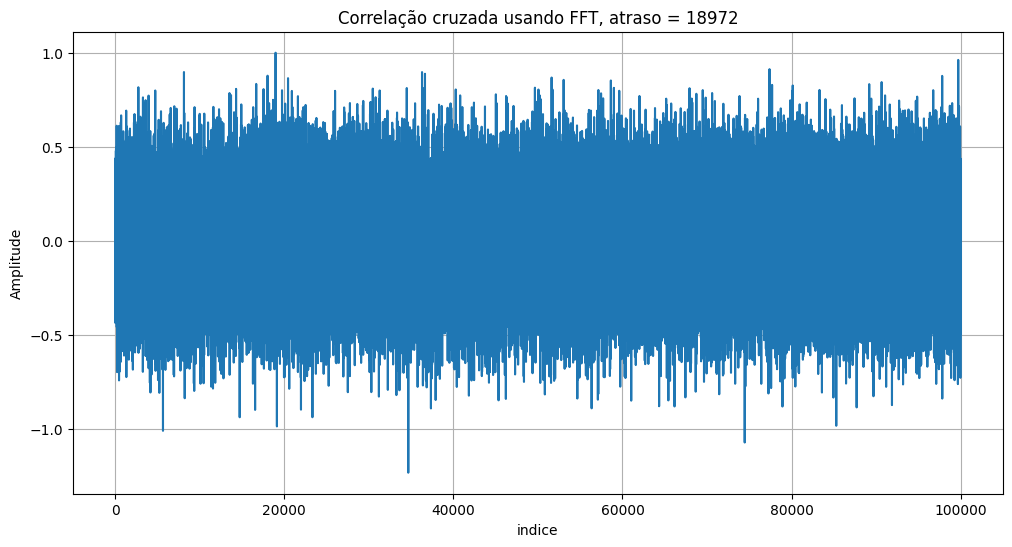

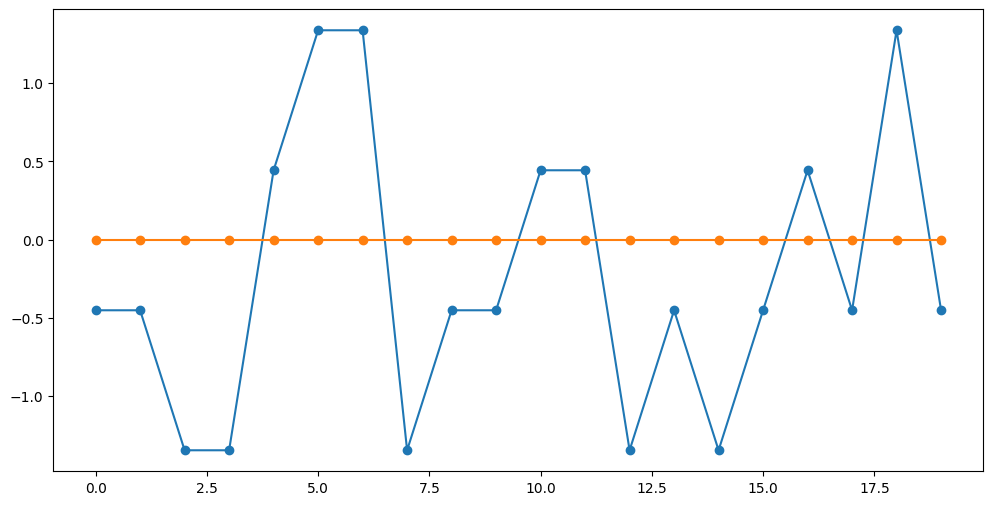

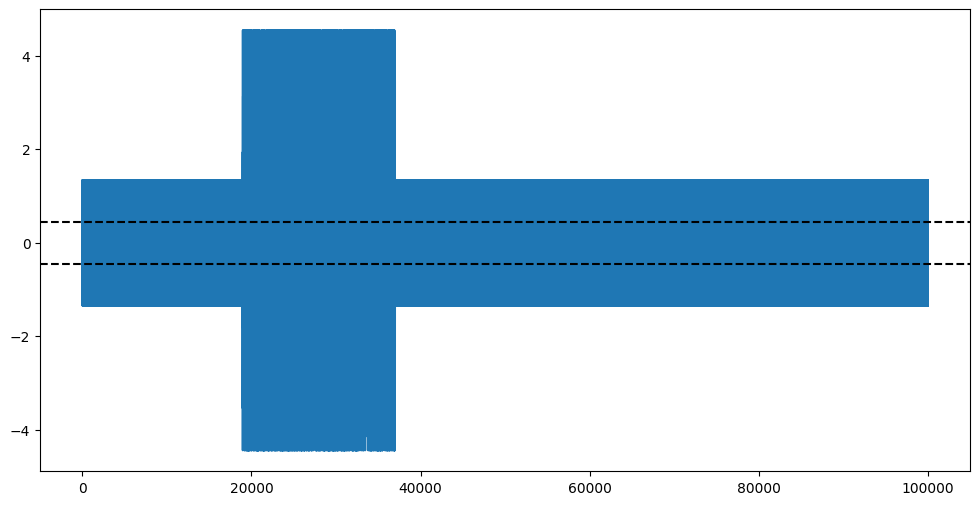

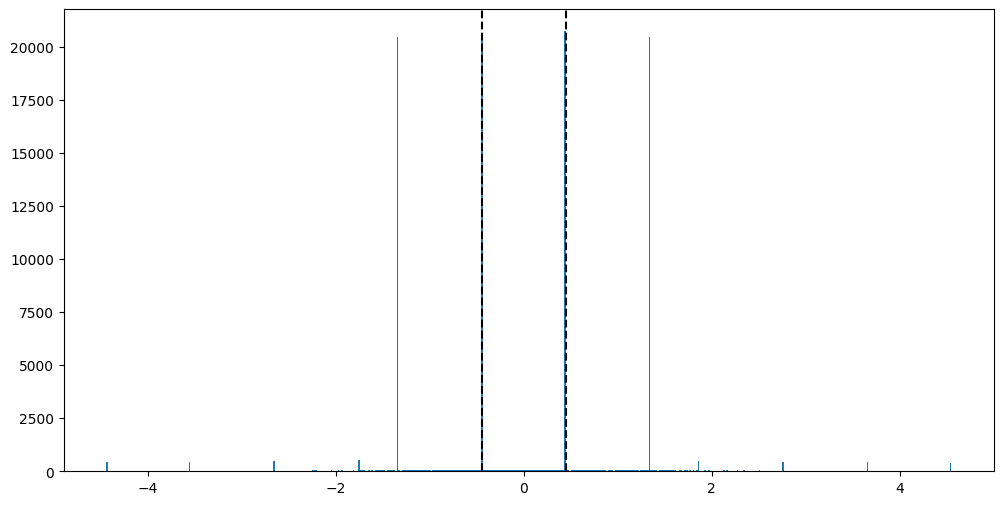

<Figure size 1200x600 with 0 Axes>

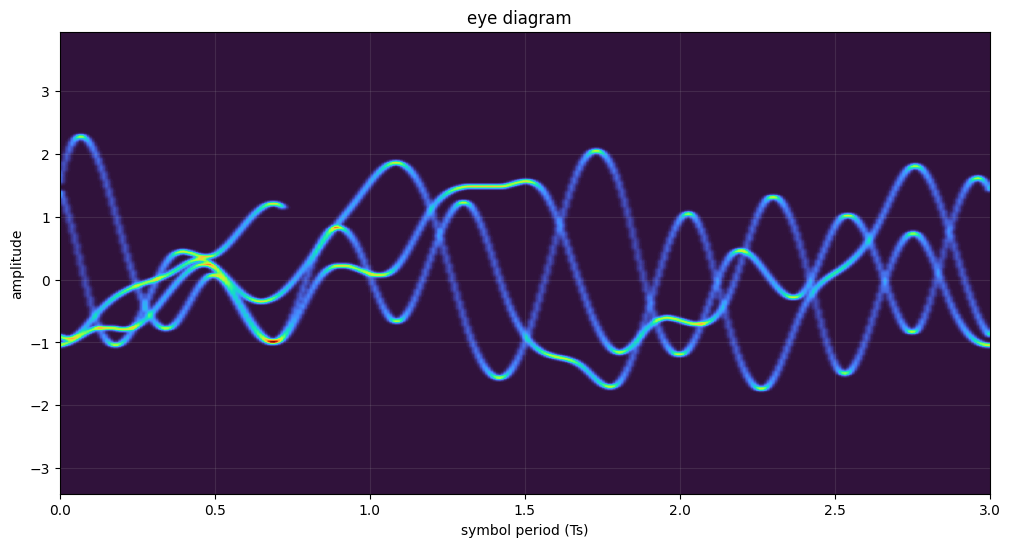

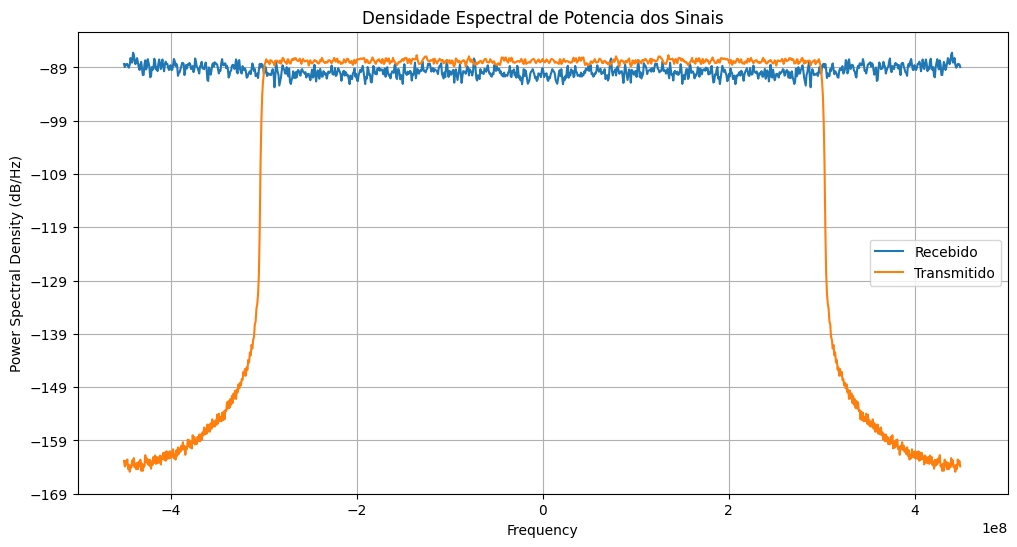

In [58]:
from optic.dsp.clockRecovery import gardnerClockRecovery
from optic.utils import parameters

# paramCLKREC = parameters()
# paramCLKREC.isNyquist = True
# paramCLKREC.returnTiming = True
# paramCLKREC.ki = 1e-20
# paramCLKREC.kp = 3e-3
# paramCLKREC.maxPPM = -20

paramCLKREC = parameters()
paramCLKREC.isNyquist = True
paramCLKREC.returnTiming = True
paramCLKREC.ki = 1e-6
paramCLKREC.kp = 1e-2
paramCLKREC.maxPPM = 1e-20

recebido = clockSamplingInterp(recebido.reshape(-1,1),Fs_in=(fsScope/Dac['fs']),Fs_out=1.5,jitter_rms=0)[:,0]


#t,recebido = AdquirirOnda(Osciloscopio['dispositivo'],3)
#fsScope = float(Osciloscopio['dispositivo'].query(':ACQuire:SRATe?'))

print(f'Numero de pontos do osciloscopio: {len(recebido)}')
print(f'Frequencia de amostragem do osciloscopio: {round(fsScope*1e-6,3)} MHz')

transmitido = pnorm(transmitido-np.mean(transmitido))
recebido = pnorm(recebido-np.mean(recebido))

pulso = pulseShape(Modulador['formatoPulso'], (1.5), Modulador['nTaps'], Modulador['alpha'])
pulso = pulso/max(abs(pulso))
filtrocasado = firFilter(pulso,recebido)
filtrocasado = pnorm(filtrocasado-np.mean(filtrocasado))
print(len(filtrocasado))
# filtrocasado, ted_values = gardnerClockRecovery(filtrocasado, paramCLKREC)
# filtrocasado = filtrocasado[:,0]

#filtrocasado = np.append(filtrocasado,np.zeros(len(transmitido)-len(filtrocasado)))

# paramDec = parameters()
# paramDec.SpS_in  = int(fsScope/Dac['fs'])
# paramDec.SpS_out = 1
# recebidodecimado = decimate(filtrocasado, paramDec)[:,0]
# recebidodecimado = pnorm(recebidodecimado-np.mean(recebidodecimado))
recebidodecimado = clockSamplingInterp(filtrocasado.reshape(-1,1),Fs_in=(1.5),Fs_out=1,jitter_rms=0)[:,0]

simbolos = modulateGray(bits,4,'pam')
simbolos = pnorm(simbolos-np.mean(simbolos))

# print((recebidodecimado.shape))
# print((simbolos.shape))

#recebidodecimado = recebidodecimado[0:len(simbolos)]
recebidosicronizado = sicronizarSinais(recebidodecimado,(simbolos),plot=True)
#recebidosicronizado = symbolSync(simbolos.reshape(-1,1), recebidodecimado.reshape(-1,1), 1)[:,0]

recebidosicronizado = recebidosicronizado[0:len(simbolos)]
recebidosicronizado = pnorm(recebidosicronizado-np.mean(recebidosicronizado))
recebidosicronizado = np.clip(recebidosicronizado,np.min(transmitido),np.max(transmitido))
recebidosicronizado = recebidosicronizado[1:-1]
simbolos = simbolos[1:-1]
# print((recebidosicronizado.shape))
# print((simbolos.shape))

plt.figure()
plt.plot((simbolos)[0:0+20],'o-')
plt.plot((recebidosicronizado)[0:0+20],'o-')

plt.figure()
diferenca = simbolos - recebidosicronizado
plt.plot(diferenca[0:])
plt.axhline(-0.4470,linestyle='--',color='k')
plt.axhline(0.4470,linestyle='--',color='k')
plt.figure()
plt.hist(diferenca,bins=500)
plt.axvline(-0.4470,linestyle='--',color='k')
plt.axvline(0.4470,linestyle='--',color='k')

ber,ser,SNRdB = (fastBERcalc(pnorm(recebidosicronizado), pnorm(simbolos), 4, 'pam'))
print(ber,ser,SNRdB)
print(ser*len(simbolos))
from scipy.special import erfc

def Q(x):
    return 0.5*erfc(x/np.sqrt(2))
SNR = 10**(SNRdB/10)
print(2*(4-1)/4*Q(np.sqrt((6*SNR)/(4**2-1))))



plt.figure()
eyediagram(filtrocasado,len(filtrocasado),(fsScope/Dac['fs']),ptype='fancy')

plt.figure()
plt.title('Densidade Espectral de Potencia dos Sinais')
plt.psd(recebido,Fs=900e6, NFFT = 1024, sides='twosided', label = 'Recebido')
plt.psd(transmitido,Fs=900e6, NFFT = 1024, sides='twosided', label = 'Transmitido')
plt.xlim(-0.5e9,0.5e9)
plt.legend()

# plt.figure()
# diferenca = transmitido - recebidosicronizado
# plt.plot(diferenca[0::len(diferenca)//1000])
#recebidodecimado = clockSamplingInterp(recebido.reshape(-1,1),Fs_in=fsScope,Fs_out=Dac['fs']*Modulador['SPS'],jitter_rms=0)[:,0]
#recebidodecimado = pnorm(recebidodecimado-np.mean(recebidodecimado))

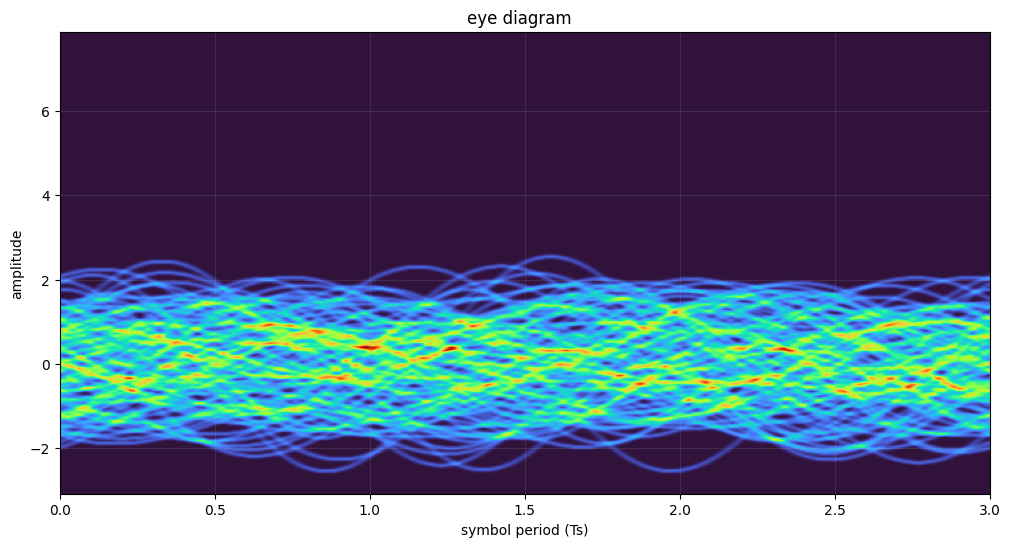

In [24]:
eyediagram(filtrocasado,len(filtrocasado),(fsScope/Dac['fs']),ptype='fancy')
